# PoseNet Tests

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML

import torch
from torch.autograd import Variable
from datasets.apolloscape import Apolloscape
from utils.common import draw_poses
from utils.common import draw_record
import numpy as np
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os
import time

from torchviz import make_dot

%matplotlib inline
plt.ion()


# Load Dataset

In [2]:
APOLLO_PATH = "./data/apolloscape"

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])

# record_name = "Record029"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road02_seg", transform=transform, record=record_name)

# record_name = "Record018" # Record018 - example with a turn
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg", transform=transform, record=record_name)

record_name = "Record008"
apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample", transform=transform, record=record_name)

print(apollo_dataset)

dataloader = DataLoader(apollo_dataset, batch_size=8)


Dataset: Apolloscape
    Road: zpark-sample
    Record: Record008
    Length: 122 of 1499
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



In [3]:
# Show images
def imshow(img, title=None):
    img = img.numpy().transpose([1, 2, 0])
    fig = plt.figure(figsize=(18, 18))
    if title is not None:
        plt.title(title)
    plt.imshow(img)
    plt.pause(0.001)

In [4]:
def collate_images(batch_samples):
    just_images = [torch.cat(x, dim=2) for x in zip(*batch_samples[0])]
    return just_images


dataloader_iter = iter(dataloader)
batch = next(dataloader_iter)

len(batch[0])

# images_col = collate_images(batch)

# img_out = vutils.make_grid(images_col, nrow=1)
# imshow(img_out, title="Batch 0")

2

In [32]:
# Create model
# feature_extractor = models.resnet18(pretrained=False)

feature_extractor = torch.nn.Sequential()
feature_extractor.add_module('conv1', torch.nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4,
                    stride=2, padding=1, bias=True))
feature_extractor.add_module('relu1', torch.nn.LeakyReLU(0.2, inplace=False))
feature_extractor.add_module('relu1', torch.nn.LeakyReLU(0.2, inplace=False))



In [38]:
test_img = torch.rand(10, 3, 224, 224)
out = feature_extractor(test_img)
# for idx, m in enumerate(feature_extractor.modules()):
#     print("{} -> {}".format(idx, m))
print('out.size = {}'.format(out.size()))

out.size = torch.Size([10, 128, 112, 112])


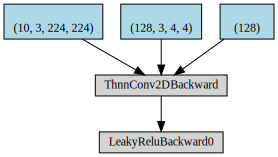

In [37]:
# for p in feature_extractor.parameters():
#     print(p.size())

# Test function for visiting backward graph
visited = set()
def visit_all(var, indent=''):
    if hasattr(var, 'data'):
        print("{}Data: {}".format(indent, var.data.size()))
    if hasattr(var, 'grad'):
        print("{}Grad Data: {}".format(indent, var.grad))
    if torch.is_tensor(var):
        print("{}Tensor {}".format(indent, var.size()))
    else:
        print("{}Type: {}".format(indent, type(var)))

    if hasattr(var, 'variable'):
        print("{}Variable: {}".format(indent, var.variable.size()))
        print("{}Data: {}".format(indent, var.variable))
        print("{}Data GRAD: {}".format(indent, var.variable.grad))
    if hasattr(var, 'saved_tensors'):
        print('{}Saved tensors: {}'.format(indent, var.saved_tensors))
    if hasattr(var, 'next_functions'):
        print('{}Next functions: {}'.format(indent, var.next_functions))
        for f in var.next_functions:
            if f[0] is not None:
                print("{}Function: {}".format(indent, f))
                visit_all(f[0], indent=indent+'  ')
    if hasattr(var, 'grad_fn'):
        print('{}Grad Fn: {}'.format(indent, var.grad_fn))
        visit_all(var.grad_fn, indent=indent+'  ')
    visited.add(var)
    
    
# visit_all(y)

# print(out.grad_fn.next_functions)

# out.__dir__()
# make_dot(out, params=dict(feature_extractor.named_parameters()))
make_dot(out)

a = tensor([ 0.3320])
b = tensor([ 0.2379])
c = tensor([ 0.8870])
y = tensor([-1.0320])
Data: torch.Size([1])
Grad Data: None
Tensor torch.Size([1])
Grad Fn: <MulBackward1 object at 0x7fa541ed6da0>
  Type: <class 'MulBackward1'>
  Next functions: ((<LogBackward object at 0x7fa541ed6c88>, 0), (<AddBackward1 object at 0x7fa541ed6cc0>, 0))
  Function: (<LogBackward object at 0x7fa541ed6c88>, 0)
    Type: <class 'LogBackward'>
    Next functions: ((<AccumulateGrad object at 0x7fa541ed6160>, 0),)
    Function: (<AccumulateGrad object at 0x7fa541ed6160>, 0)
      Type: <class 'AccumulateGrad'>
      Variable: torch.Size([1])
      Data: tensor([ 0.3320])
      Data GRAD: None
      Next functions: ()
  Function: (<AddBackward1 object at 0x7fa541ed6cc0>, 0)
    Type: <class 'AddBackward1'>
    Next functions: ((<AccumulateGrad object at 0x7fa541ed6668>, 0), (<PowBackward0 object at 0x7fa541ed69e8>, 0))
    Function: (<AccumulateGrad object at 0x7fa541ed6668>, 0)
      Type: <class 'Accumulate

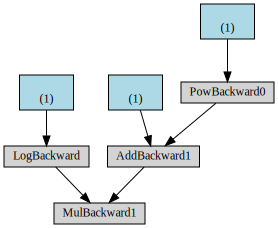

In [39]:
# Simple experiment to check backward graph state
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
c = torch.rand(1, requires_grad=True)
y = torch.log(a) * (b + torch.pow(c, 3))
print('a = {}'.format(a))
print('b = {}'.format(b))
print('c = {}'.format(c))
print('y = {}'.format(y))

visit_all(y)

print('--- BACKWARD ---')
y.backward()
visit_all(y)

make_dot(y)